In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer
import torch
import torchvision
from lava.lib.dl import netx

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d

random_seed = 15
import torch
torch.manual_seed(random_seed)
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)


In [2]:
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val

In [3]:
# Get validation data
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        transforms.Lambda(lambda x: x.view(3, 1024).t())
    ])
transform_train = transform_test = transform

# Datasets
trainset = torchvision.datasets.CIFAR10(
    root='./data/cifar/', train=True, download=True, transform=transform_train)
trainset, val = split_train_val(trainset, val_split=0.1)

testset = torchvision.datasets.CIFAR10(
    root='./data/cifar/', train=False, download=True, transform=transform_test)

val_loader = torch.utils.data.DataLoader(dataset=val , batch_size=1, shuffle=True, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
label, data_sample = next(enumerate(val_loader))
print(label)
print(data_sample[0].detach().max())
print(data_sample[0].detach().min())

0
tensor(1.7581)
tensor(-2.0414)


In [5]:
from lava.lib.dl.slayer.state_space_models.sCIFAR.network import SCIFARNetwork
inp_exp = 12
data_rescaled = torch.transpose(data_sample[0], -1,-2) * 2**inp_exp
diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
diff_inp = np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2) 

# differences
d_model = 128
n_states = 64
lava_dl_model = SCIFARNetwork(d_model=d_model, n_states=n_states)
a = lava_dl_model(torch.from_numpy(diff_inp))

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


wee are here


In [6]:
lava_dl_model.export_hdf5("debug.net")
loaded_net =  netx.hdf5.Network(net_config='debug.net', input_message_bits=24, sparse_fc_layer=True)
os.remove("debug.net")
print(loaded_net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|


In [7]:
# get output from loaded lava net
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.proc.dense.process import Dense
from lava.proc.s4d.ncmodels import NcModelSigmaS4dDelta
from lava.proc.s4d.process import SigmaS4dDelta
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter

# Enable SLURM, the workload manager used to distribute Loihi2 resources to users
os.environ['SLURM'] = '1'
os.environ['PARTITION'] = "oheogulch"
os.environ['LOIHI_GEN'] = "N3C1"

n_steps = 1024

spiker = SourceBuffer(data=diff_inp.reshape(3,1024))
adapter_i = PyToNxAdapter(shape=(3,), num_message_bits=24)
adapter_o = NxToPyAdapter(shape=(128,), num_message_bits=24)
receiver = SinkBuffer(buffer = n_steps, shape=(128,))


spiker.s_out.connect(adapter_i.inp)
adapter_i.out.connect(loaded_net.inp)
loaded_net.out.connect(adapter_o.inp)
adapter_o.out.connect(receiver.a_in)

exception_map = {SigmaS4dDelta : NcModelSigmaS4dDelta}
run_cfg = Loihi2HwCfg(exception_proc_model_map=exception_map)

run_cfg = Loihi2HwCfg()

In [8]:
from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
CompilerOptions.verbose = True
sigma = np.zeros(n_steps)
S4state = np.zeros(n_steps)

for time_step in range(n_steps):
        spiker.run(
            condition=RunSteps(num_steps=1), run_cfg=Loihi2HwCfg()
        )    
received_data_lava = receiver.data.get()
spiker.stop()

Partitioning converged after iteration=7
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|  51.20%|  12.50%|   1.54%|  25.20%|   0.39%|   0.00%|  61.76%|       3|
|   0.80%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.59%|       5|
|  51.20%|  12.50%|   1.54%|  25.20%|   0.39%|   0.00%|  61.76%|       3|
|   0.80%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.59%|       5|
|  51.20%|  12.50%|   1.54%|  25.20%|   0.39%|   0.00%|  61.76%|       3|
|   0.80%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.59%|       5|
|  51.20%|  12.50%|   1.54%|  25.20%|   0.39%|   0.00%|  61.76%|       3|
|   0.80%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.59%|       5|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|------------------------------------------------

/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


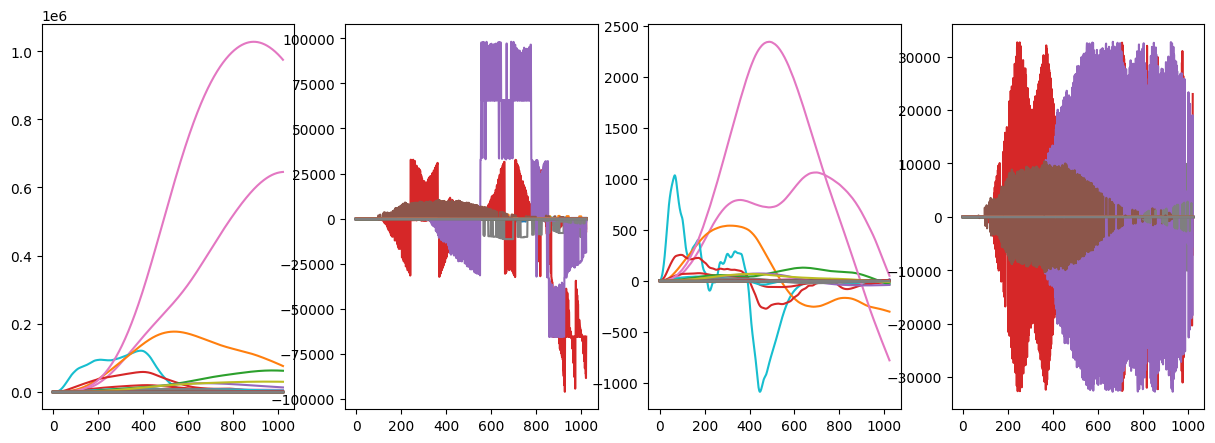

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(np.cumsum(a[0].detach().numpy(), axis=1).T);
axs[1].plot(np.cumsum(received_data_lava.astype(np.int16), axis=1)[:, 2:].T);

axs[2].plot(a[0].detach().numpy().T);
axs[3].plot(received_data_lava[:, 2:].T.astype(np.int16));